In [7]:
import re


def camel_to_snake(name: str) -> str:
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()


class ATest:
    @staticmethod
    def name() -> str:
        return 

In [8]:
from typing import Any
from collections import defaultdict
import numpy as np
from gymnasium import ObservationWrapper, spaces, Wrapper

class CustomObservationWrapper(ObservationWrapper):
    def reset(self, *, seed: int | None = None, options: dict[str, Any] | None = None) -> tuple[Any, dict[str, Any]]:
        return super().reset(seed=seed, options=options)

class RewardObs(CustomObservationWrapper):
    def __init__(self, env, reward, *args, **kwargs):
        super().__init__(env, *args, **kwargs)
        self.reward = reward

    @property
    def observation_space(self):
        return self.reward.observation_space
    
    @property
    def keys_to_log(self) -> set[str]:
        if not self.reward:
            return set([])
        return self.reward.keys_to_log

    def observation(self, obs):
        obs = self.reward.observation(obs)
        return obs


class Basic2DObs(RewardObs, Wrapper):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cum_sum = defaultdict(float)

    def reset(self, *args, **kwargs):
        self.cum_sum.clear()
        return super().reset(*args, **kwargs)
    
    @property
    def observation_space(self):
        return spaces.Dict({
            **super().observation_space,
            'v_angle': spaces.Box(low=-np.pi, high=np.pi, shape=(1,)),
            'v_norm': spaces.Box(low=0, high=np.inf, shape=(1,)),
            'theta_boat': spaces.Box(low=-np.pi, high=np.pi, shape=(1,)),
            'dt_theta_boat': spaces.Box(low=-np.inf, high=np.inf, shape=(1,)),
            'theta_rudder': spaces.Box(low=-np.pi, high=np.pi, shape=(1,)),
            'dt_theta_rudder': spaces.Box(low=-np.inf, high=np.inf, shape=(1,)),
            'wind_angle': spaces.Box(low=-np.pi, high=np.pi, shape=(1,)),
            'wind_norm': spaces.Box(low=0, high=np.inf, shape=(1,)),
        })

    @property
    def keys_to_log(self):
        return super().keys_to_log | set([])

    def observation(self, obs):
        # v = obs['dt_p_boat'][0:2]
        # v_angle = np.arctan2(v[1], v[0])

        # wind = obs['wind']
        # wind_angle = np.arctan2(wind[1], wind[0])

        # obs = {
        #     **super().observation(obs),
        #     'v_angle': v_angle,
        #     'v_norm': v_norm,
        #     'theta_boat': obs['theta_boat'][2],  # Z axis
        #     'dt_theta_boat': obs['dt_theta_boat'][2],  # Z axis
        #     'theta_rudder': obs['theta_rudder'][0],
        #     'dt_theta_rudder': obs['dt_theta_rudder'][0],
        #     'wind_angle': wind_angle,
        #     'wind_norm': wind_norm,
        # }
        print(self.keys_to_log)

        log_obs = {k: v for k, v in obs.items() if k in self.keys_to_log}
        for k, v in list(log_obs.items()):
            self.cum_sum[k] += v
            log_obs[f'cum_{k}'] = self.cum_sum[k]
        # log(log_obs, prefix='obs')

        return obs
    
Basic2DObs(None, None).observation({})

set()


{}

In [2]:
class A:
    @property
    def a(self):
        return set(['a'])
    
class AA(A):
    @property
    def a(self):
        return super().a | set([])
    
AA().a

{'a'}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
def compute_los(pos, path, radius):
  p1, p2 = path - pos # center on pos
  dx, dy = p2 - p1 + 1e-8 # avoid div by 0
  dr = np.sqrt(dx**2 + dy**2)
  D = p1[0]*p2[1] - p2[0]*p1[1]
  delta = radius**2 * dr**2 - D**2

  def compute_inter(sign=1):
    return np.array([
      D*dy + sign * np.sign(dy)*dx*np.sqrt(delta),
      -D*dx + sign * np.abs(dy)*np.sqrt(delta),
    ]) / dr**2

  if delta < 0:
    return []
  elif delta == 0:
    return [compute_inter()]
  else:
    return [compute_inter(-1), compute_inter(1)]

def compute_sign_dist(pos, path):
  p1, p2 = path
  dx_path, dy_path = p2 - p1 + 1e-8 # avoid div by 0
  dr = np.sqrt(dx_path**2 + dy_path**2)
  dx_pos, dy_pos = p1 - pos
  return (dx_path*dy_pos - dy_path*dx_pos) / dr

(array([3.023467  , 0.11812565]), -0.07071067811865472)

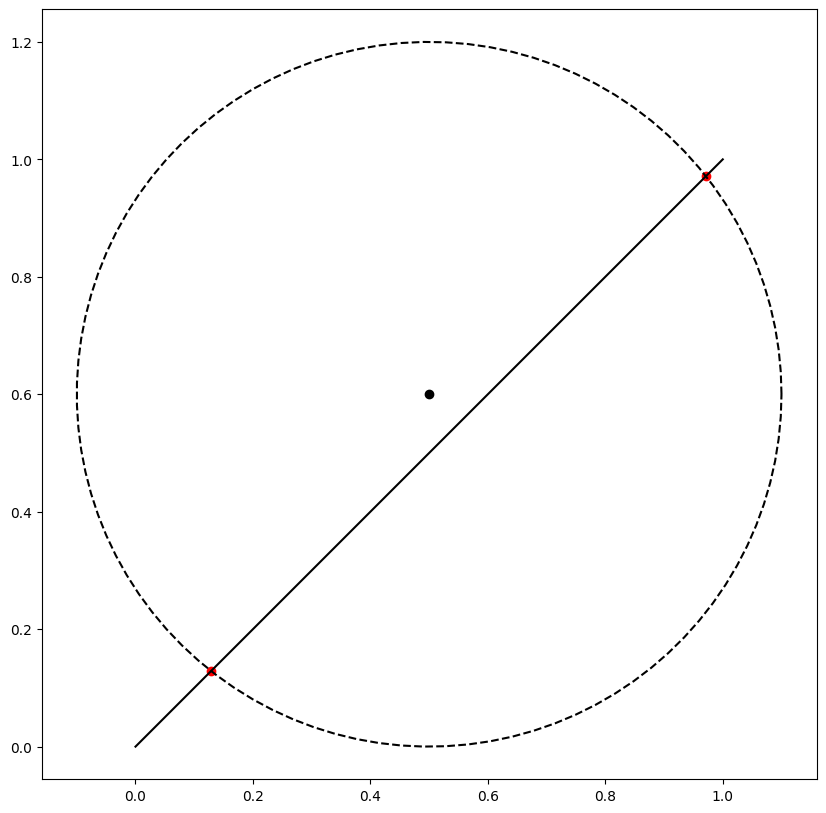

In [77]:
path = np.array([[0, 0], [1, 1]]).astype(float)
radius = .6
pos = np.array([.5, .6])
inters = compute_los(pos, path, radius)

plt.figure(figsize=(10, 10))
plt.plot(path[:, 0], path[:, 1], 'k')
plt.plot(pos[0], pos[1], 'ko')
t = np.linspace(0, 2*np.pi, 100)
plt.plot(pos[0] + radius*np.cos(t), pos[1] + radius*np.sin(t), 'k--')
plt.axis('equal')
for p in inters:
  plt.scatter(*(pos + p), c='r')


los = np.array(inters)
los /= np.linalg.norm(los, axis=1)[:, None] # normalize

path_v = path[1] - path[0]
path_v /= np.linalg.norm(path_v) # normalize

path_los_angle = np.arccos(los@path_v)
target_angle = min([*path_los_angle, np.pi/2])
# target_angle *= np.sign(np.cross(path_v, los))

path_los_angle, compute_sign_dist(pos, path)

In [13]:
inters

array([[0.1, 0.4],
       [0.1, 0.4]])

In [16]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

In [9]:
a = np.load('pid-2.npz')['a']

In [12]:
a.shape

(100, 2)

In [34]:
x = a[:,0][:,None]
y = a[:,1]

reg = LinearRegression(fit_intercept=False).fit(x, y)
reg.score(x, y), reg.coef_, reg.intercept_

(0.9830108360718255, array([0.5477039]), 0.0)

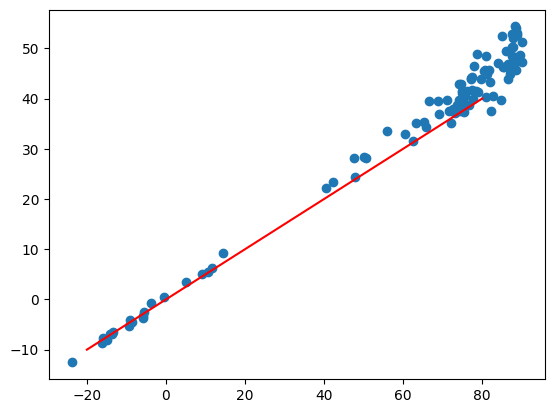

In [39]:
plt.scatter(*a.T)
x = np.linspace(-20, 80, 100)
plt.plot(x, .5*x, color='red')

In [11]:
from scipy.stats import rv_continuous
import numpy as np
import matplotlib.pyplot as plt

def pdf(x):
    if x < 0:
        return 0
    if x > 1:
        return 1
    return np.abs(x)

class CustomDist(rv_continuous):
    "Gaussian distribution"
    def _pdf(self, x):
        if x < -1 or x > 1:
            return 0
        return 1 - np.abs(x)
        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)
gaussian = CustomDist(name='gaussian')

gaussian.rvs(size=10)

# x = np.linspace(-4, 4, 100)
# plt.plot(x, [pdf(xi) for xi in x])
# plt.show()

RuntimeError: Failed to converge after 100 iterations.